In [3]:
pip install rasterio

     |████████████████████████████████| 18.2MB 1.2MB/s 


In [4]:
pip install geopandas

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 14.5MB/s 
     |████████████████████████████████| 14.7MB 254kB/s 


In [5]:
#Permitir acesso ao google drive
#cole a senha e aperte enter
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Pacotes - tem alguns que não são utilizados e outros que tão duplicados.
import os
from itertools import product
import skimage
import skimage.io
import numpy as np

import rasterio as rio
from rasterio import windows
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

In [0]:
def deleteAlphaBand(imagePath,savePath,saveName):
  """
  Function to delete the alpha band from RPA images and reduce its memory size.

    Parameters:
    imagePath (string) = path to the .tif image.
    savePath (string) = path to save the image.
    saveName (string) = name of the saved file.
  
  """
  with rio.open(imagePath) as src:
    # Open the red band
    redBand = src.read(1)
    # Open the green band
    greenBand = src.read(2)
    # Open the blue band
    blueBand = src.read(3)

    # Edit the metadata
    kwargs = src.meta
    kwargs.update(
    count = 3)

    # Save the data
    with rio.open(f"{savePath}/{saveName}.tif",'w', **kwargs) as dst:
      # Write the bands
      print("Saving...")
      dst.write_band(1,redBand)
      dst.write_band(2,greenBand)
      dst.write_band(3,blueBand)

In [0]:
# PAY ATTENTION!!!! Input TIF file must be georeferenced on UTM coordinates!!!
deleteAlphaBand(imagePath="/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Mosaic_Cecropia_AOI_UTM.tif",
                savePath ="/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017",
                saveName = "Mosaic_Cecropia_AOI_RGB")

Saving...


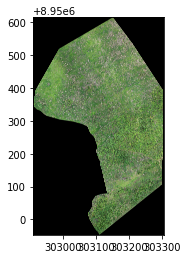

In [0]:
# load result
from rasterio.plot import show


with rio.open("/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017/Mosaic_Cecropia_AOI_RGB.tif") as src:
  show(src)

In [0]:
# Check number of bands (count)
src.meta

{'count': 3,
 'crs': CRS.from_epsg(32720),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 27828,
 'nodata': None,
 'transform': Affine(0.023499480366107002, 0.0, 302907.6165,
       0.0, -0.023742417708779308, 8950614.2129),
 'width': 16935}

In [0]:
# Teste de overlap 2 linhas e 2 colunas

def patch_images(input_path,  output_path, size):
    
    """Function patch_images - Patch the images in an specific size to a folder.
    
    Parameters:
    
    input_path(string) = path where the image file is located
    
    output_path(string) = path where the image tiles is located
    
    size (int) = crop size(width and height size will be the same during the crop)
    
    
    """

    size = size
    i = 0
    in_path = input_path    


    out_path = output_path
    # se quiser mudar o nome das imagens que serão salvas é so mudar aqui.
    # recomendo deixar as chaves aqui, pq no final o loop vai adicionar um número em ordem crescente. 
    output_filename = 'tile_{}.tif'

    # Código adaptado da internet, basicamente é uma janela móvel que vai se deslocando pela imagem e recortando na dimensão desejada.
    def get_tiles(ds, width=size, height=size):
        nols, nrows = ds.meta['width'], ds.meta['height']
        offsets = product(range(0, nols, width-2), range(0, nrows, height-2))
        big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
        for col_off, row_off in  offsets:
            window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
            transform = windows.transform(window, ds.transform)
            yield window, transform


    # Salvar as coordenadas nos pedaços que serão gerados
    with rio.open(input_path) as inds:
        tile_width, tile_height = size, size

        meta = inds.meta.copy()

        for window, transform in get_tiles(inds):
            print(window)
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            i += 1
            outpath = os.path.join(out_path,output_filename.format(i))
            with rio.open(outpath, 'w', **meta) as outds:
                outds.write(inds.read(window=window))

In [0]:
# Teste de aplicação de overlap 2 linhas e 2 colunas

from timeit import default_timer as timer

start = timer()

# images
patch_images(input_path = "/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017/Mosaic_Cecropia_AOI_RGB.tif",
             output_path = "/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017/Patch_Overlap2x2",
             size = 128) # pode escolher a dimensão que quiser, mas mantém múltiplo de 32 pra Unet


end = timer()
print(end - start)

Streaming output truncated to the last 5000 lines.
Window(col_off=14112, row_off=10710, width=128, height=128)
Window(col_off=14112, row_off=10836, width=128, height=128)
Window(col_off=14112, row_off=10962, width=128, height=128)
Window(col_off=14112, row_off=11088, width=128, height=128)
Window(col_off=14112, row_off=11214, width=128, height=128)
Window(col_off=14112, row_off=11340, width=128, height=128)
Window(col_off=14112, row_off=11466, width=128, height=128)
Window(col_off=14112, row_off=11592, width=128, height=128)
Window(col_off=14112, row_off=11718, width=128, height=128)
Window(col_off=14112, row_off=11844, width=128, height=128)
Window(col_off=14112, row_off=11970, width=128, height=128)
Window(col_off=14112, row_off=12096, width=128, height=128)
Window(col_off=14112, row_off=12222, width=128, height=128)
Window(col_off=14112, row_off=12348, width=128, height=128)
Window(col_off=14112, row_off=12474, width=128, height=128)
Window(col_off=14112, row_off=12600, width=128, h

In [0]:
# Renomear os arquivos,  por exemplo, de "tile_1" para "image0"
# ATENÇÃO para inserir "/" no final de cada path
import os 
  
# Function to rename multiple files 
def main(): 
  
    for count, filename in enumerate(os.listdir("/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017/Patch_Overlap2x2/")): 
        numero = count# + 1
        dst ="image" + str(numero) + ".tif"
        src ="/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017/Patch_Overlap2x2/"+ filename 
        dst ="/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017/Patch_Overlap2x2/" + dst
          
        # rename() function will 
        # rename all the files 
        os.rename(src, dst) 
  
# Driver Code 
if __name__ == '__main__': 
      
    # Calling main() function 
    main() 

In [0]:
# Renomear os arquivos,  por exemplo, de "tile_1" para "image0"
# ATENÇÃO para inserir "/" no final de cada path

enumerate(os.listdir("/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017/Patch_Overlap2x2/"))

In [0]:
# Gerar shapes contendo a delimitação de cada tile (parte1)

def generateShapefileFromTiles(tilesList,saveFolder):
  """Function to automatically generate shapefiles with the same size and name of the tiles from a folder

  Parameters:

  tilesList (list) = "List with the path to all tiles"
  saveFolder = "Path to save the shapefiles"
  """
  # Loop over all files in tilesList
  for tile in tilesList:
    name = tile.split("/")[-1]
    print(f"File: {name}")
    # Get the name of the number from the image name
    tileName = tile.split("image")[-1]
    tileName = tileName.split(".tif")[0]
    # Open the image
    with rio.open(tile) as src:
      # Get the cordinate reference system (crs)
      crs = src.crs
      # Get lat and long bounds
      latMax = src.bounds[2]
      latMin = src.bounds[0]
      longMax = src.bounds[3]
      longMin = src.bounds[1]
    # Create a polygon with the coordinates
    list_polygon = []
    long = [latMax, latMin, latMin,latMax,latMax] 
    lat = [longMax,longMax,longMin, longMin,longMax]
    list_polygon.append(Polygon(zip(long,lat)))
    polygon = gpd.GeoDataFrame(crs=crs, geometry=list_polygon) 
    # Save as shapefile
    print(f"Shapefile: shape{tileName}.shp was saved in: {saveFolder}")
    polygon.to_file(filename=f"{saveFolder}/shape{tileName}.shp")

In [10]:
# Gerar shapes contendo a delimitação de cada tile  (parte2)

from glob import glob

# get all .tif files from the folder

files = glob("/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017/Patch_Overlap2x2/*.tif")
print(files)

[]


In [0]:
# Gerar shapes contendo a delimitação de cada tile  (parte3)

# Run the function
generateShapefileFromTiles(tilesList=files,saveFolder ="/content/drive/My Drive/Projetos_Doutorado/Rondonia_Embrapa/09Dez2019_RF2016_2017/Mask_RCNN/Tiles_RF2016_2017/Patch_Overlap2x2" )